PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import h5py

## Import data and add noise

### Cartesian Fourier operator and noise

In [3]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

u0_mat = (1+0j)*im[ :, 30:206, 124 ]

In [4]:
(n,m) = u0_mat.shape
x = np.linspace(0,m,m,endpoint=False)/m-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

mask = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

# Adding noise
s = 0.1*np.mean(u0_mat)
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+s*np.random.randn(2*n*m).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Creating a random cartesian mask or projecting a radial mask on cartesian grid

In [5]:
x = np.linspace( -0.5, 0.5, m, endpoint = False )
p = np.array([norm.pdf(u,loc=0,scale=0.15) for u in x])
p /= np.sum(p)
y_sampled = np.random.choice( x, size=int(0.6*m), p=p, replace=False)

#Subsampling: From pysap radial mask 
cartesian_p = np.zeros((n*m+1,))
cartesian_p[-1] = 25
for yi in y_sampled:
    j=int((yi+0.5)*n)
    cartesian_p[j*n:(j+1)*n] = np.ones((n,))
pysap.Image(data=np.reshape(cartesian_p[:-1],(m,n)).transpose()).show()

### Operators

In [6]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=3,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [7]:
#ifft on noised data = base result
uk = fourier_op.adj_op(y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.real(uk)).show()
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

0.8157645283430403


## Reconstruction

In [8]:
# Specific files import
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import f1,f2,g

In [9]:
param = {"epsilon":1e-3,"gamma":1e-10}

In [10]:
print(g(u0_mat,param["epsilon"]),
      f2(linear_op.op(u0_mat),cartesian_p[-1],param["gamma"]),
      f1(u0_mat,cartesian_p[:-1],y,fourier_op))

493727.504 30491721.465768337 7920938.462447648


In [11]:
# -- Solving --
#p0=cartesian_p
p0 = np.ones(n**2+1)
p0[-1] = 30
uk,norms,energy,ssims = pdhg(y , p0 ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             ground_truth=u0_mat,
                             const = {"sigma":5,"tau":0.1},
                             maxit=100,
                             compute_energy = True,
                             mask_type="cartesian")

Sigma: 5 
Tau: 0.1


/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


10  iterations:
Cost: 40928869.14878703 
Norm: 0.05915423366524007 

20  iterations:
Cost: 39806743.958330765 
Norm: 0.01592329326836338 

30  iterations:
Cost: 39667970.315466605 
Norm: 0.004587809719302517 

40  iterations:
Cost: 39649371.19083513 
Norm: 0.0014881944402753376 

50  iterations:
Cost: 39646740.490952194 
Norm: 0.0005072697145673471 

60  iterations:
Cost: 39646358.9771016 
Norm: 0.0001733230415156752 

70  iterations:
Cost: 39646306.39439113 
Norm: 6.532085411060699e-05 

80  iterations:
Cost: 39646298.65190615 
Norm: 2.4307647175537007e-05 

90  iterations:
Cost: 39646297.5214727 
Norm: 9.401777268031702e-06 

100  iterations:
Cost: 39646297.31317769 
Norm: 3.3909132267196607e-06 

Finished in 7.964839696884155 seconds.


In [12]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.abs(uk)).show()

0.9116079122647066


In [13]:
print(g(uk,param["epsilon"]),
      f2(linear_op.op(uk),cartesian_p[-1],param["gamma"]),
      f1(uk,cartesian_p[:-1],y,fourier_op))

467391.24246786645 24334310.067229733 6200293.258095679


In [14]:
pysap.Image(data = np.abs(np.abs(uk)-u0_mat)).show()

In [15]:
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

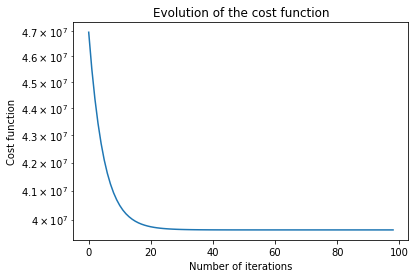

In [16]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Results/radial V cartesian/cartesian/energy.png")
plt.show()

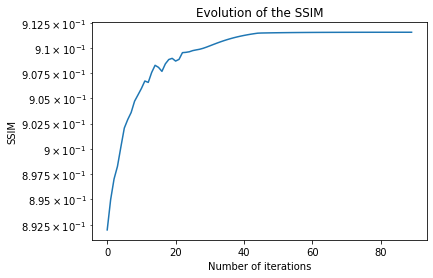

In [17]:
plt.plot(ssims[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Results/radial V cartesian/cartesian/metrics.png")
plt.show()

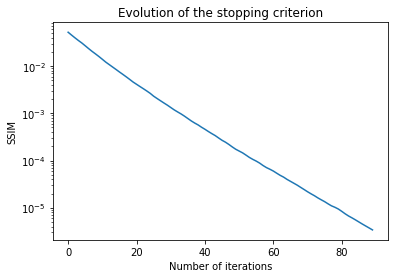

In [18]:
plt.plot(norms[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Results/radial V cartesian/cartesian/convergence.png")
plt.show()